In [1]:
# =================================================================
# Project: Adapting from Sentence-level to Document-level Sentiment Analysis
# Phase 3: Iterative Prompt Optimization on IMDb Dataset
# =================================================================

# Import libraries
import torch
import time
import os
import random
import json
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
import re

# =================================================================
# ENVIRONMENT SETUP
# =================================================================

# Set Hugging Face cache directory to a larger, persistent volume
cache_dir = "/output/huggingface_cache"
os.environ['HF_HOME'] = cache_dir
os.environ['HF_DATASETS_CACHE'] = os.path.join(cache_dir, "datasets")
os.environ['TRANSFORMERS_CACHE'] = os.path.join(cache_dir, "models")

# Prevent tokenizer parallelism issues
os.environ["TOKENIZERS_PARALLELISM"] = "false"

# Ensure the cache directory exists
os.makedirs(cache_dir, exist_ok=True)
print(f"✅ [SETUP] Hugging Face cache directory set to: {cache_dir}")

device = 'cuda' if torch.cuda.is_available() else 'cpu'

try:
    from unsloth import FastLanguageModel
    from peft import PeftModel
    from datasets import load_dataset
    from transformers import AutoTokenizer
    print("✅ [CHECKPOINT] Imports successful")
except ImportError as e:
    print(f"❌ ImportError: {e}")
    raise

# --- Basic Setup ---
print("CUDA available:", torch.cuda.is_available())
print(f"Using device: {device}")
if torch.cuda.is_available():
    print(f"- Device: {torch.cuda.get_device_name(0)}")

def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)
set_seed(42)
print("✅ [CHECKPOINT] Seed set")

✅ [SETUP] Hugging Face cache directory set to: /output/huggingface_cache
🦥 Unsloth: Will patch your computer to enable 2x faster free finetuning.


/usr/local/lib/python3.10/dist-packages/transformers/utils/hub.py:111: FutureWarning: Using `TRANSFORMERS_CACHE` is deprecated and will be removed in v5 of Transformers. Use `HF_HOME` instead.
  warnings.warn(


🦥 Unsloth Zoo will now patch everything to make training faster!
✅ [CHECKPOINT] Imports successful
CUDA available: True
Using device: cuda
- Device: NVIDIA GeForce RTX 3090
✅ [CHECKPOINT] Seed set


In [2]:
# =================================================================
# MODEL AND DATA LOADING
# =================================================================

# --- Configuration ---
STUDENT_MODEL_NAME = "unsloth/Llama-3.2-1B-unsloth-bnb-4bit"
TEACHER_MODEL_NAME = "unsloth/Llama-3.1-8B-Instruct-unsloth-bnb-4bit"
ADAPTER_PATH = "./train_outputs/sst2_finetune/final_adapter" 
OUTPUT_DIR = "./optimization_results"
STUDENT_MAX_SEQ_LENGTH = 8192
TEACHER_MAX_SEQ_LENGTH = 32768
NUM_OPTIMIZATION_STEPS = 20

# Ensure output directory exists
os.makedirs(OUTPUT_DIR, exist_ok=True)

# --- Load Student Model (Fine-tuned on SST2) ---
print(f"Loading Student Model: {STUDENT_MODEL_NAME} with adapter from {ADAPTER_PATH}")
try:
    student_model, student_tokenizer = FastLanguageModel.from_pretrained(
        model_name=STUDENT_MODEL_NAME,
        max_seq_length=STUDENT_MAX_SEQ_LENGTH,
        load_in_4bit=True,
    )
    student_model.load_adapter(ADAPTER_PATH)
    print("✅ [CHECKPOINT] Student model and adapter loaded successfully.")
except Exception as e:
    print(f"❌ Failed to load student model: {e}")
    raise

# --- Load Teacher Model ---
print(f"Loading Teacher Model: {TEACHER_MODEL_NAME}")
try:
    teacher_model, teacher_tokenizer = FastLanguageModel.from_pretrained(
        model_name=TEACHER_MODEL_NAME,
        max_seq_length=TEACHER_MAX_SEQ_LENGTH,
        load_in_4bit=True,
    )
    print("✅ [CHECKPOINT] Teacher model loaded successfully.")
except Exception as e:
    print(f"❌ Failed to load teacher model: {e}")
    raise
    
# --- Load IMDb Dataset ---
print("Loading IMDb test dataset...")
try:
    imdb_dataset = load_dataset("imdb", split="test")
    print(f"✅ [CHECKPOINT] IMDb dataset loaded with {len(imdb_dataset)} examples.")
    # Randomly sample 1000 examples for optimization
    imdb_dataset = imdb_dataset.shuffle(seed=42).select(range(1000))
    print(f"✅ [CHECKPOINT] IMDb dataset shuffled and reduced to {len(imdb_dataset)} examples.")
except Exception as e:
    print(f"❌ Failed to load IMDb dataset: {e}")
    raise

Loading Student Model: unsloth/Llama-3.2-1B-unsloth-bnb-4bit with adapter from ./train_outputs/sst2_finetune/final_adapter
==((====))==  Unsloth 2025.6.2: Fast Llama patching. Transformers: 4.52.4.
   \\   /|    NVIDIA GeForce RTX 3090. Num GPUs = 1. Max memory: 23.684 GB. Platform: Linux.
O^O/ \_/ \    Torch: 2.7.0+cu126. CUDA: 8.6. CUDA Toolkit: 12.6. Triton: 3.3.0
\        /    Bfloat16 = TRUE. FA [Xformers = 0.0.30. FA2 = False]
 "-____-"     Free license: http://github.com/unslothai/unsloth
Unsloth: Fast downloading is enabled - ignore downloading bars which are red colored!
✅ [CHECKPOINT] Student model and adapter loaded successfully.
Loading Teacher Model: unsloth/Llama-3.1-8B-Instruct-unsloth-bnb-4bit
==((====))==  Unsloth 2025.6.2: Fast Llama patching. Transformers: 4.52.4.
   \\   /|    NVIDIA GeForce RTX 3090. Num GPUs = 1. Max memory: 23.684 GB. Platform: Linux.
O^O/ \_/ \    Torch: 2.7.0+cu126. CUDA: 8.6. CUDA Toolkit: 12.6. Triton: 3.3.0
\        /    Bfloat16 = TRUE. FA 

In [3]:
# =================================================================
# HELPER FUNCTIONS
# =================================================================

label_map = {0: "Negative", 1: "Positive"}

# Define a base template that will not change.
BASE_PROMPT_TEMPLATE = """Below is an instruction that describes a task. Write a response that appropriately completes the request.

### Instruction:
{instruction}

### Input:
{review}

### Response:
{response}"""


def evaluate_on_imdb(model, tokenizer, prompt_template, dataset):
    """Evaluates the student model on the full provided IMDb dataset."""
    model.eval()
    logs = []
    correct_predictions = 0
    failure_cases = []
    num_samples = len(dataset)

    for i in tqdm(range(num_samples), desc="Evaluating on IMDb"):
        sample = dataset[i]
        text = sample["text"]
        true_label_str = label_map.get(sample["label"])
        
        prompt = prompt_template.format(review=text, response="")
        inputs = tokenizer(prompt, return_tensors="pt", truncation=True, max_length=STUDENT_MAX_SEQ_LENGTH).to(device)

        with torch.no_grad():
            outputs = model.generate(**inputs, max_new_tokens=5, pad_token_id=tokenizer.eos_token_id)
        
        prediction_text = tokenizer.decode(outputs[0][len(inputs.input_ids[0]):], skip_special_tokens=True).strip()
        predicted_label = "Positive" if "Positive" in prediction_text else "Negative" if "Negative" in prediction_text else "Unknown"
        
        is_correct = (predicted_label == true_label_str)
        if is_correct:
            correct_predictions += 1
        else:
            if len(failure_cases) < 5: 
                failure_cases.append({"text": text[:500] + "...", "raw_output": prediction_text, "actual": true_label_str})

        logs.append({
            "is_correct": is_correct,
            "prediction_text": prediction_text,
            "prediction": predicted_label, 
            "ground_truth": true_label_str
        })

    accuracy = (correct_predictions / num_samples) * 100
    return accuracy, logs, failure_cases

def create_meta_prompt(instruction_history, failures):
    """Creates a meta-prompt that asks the teacher to refine the instruction part, considering past attempts."""

    # [FIX] Get the best instruction from the entire history.
    best_instruction_so_far = max(instruction_history, key=lambda x: x['accuracy'])
    best_instruction_str = (
        f"- Best Instruction (Accuracy: {best_instruction_so_far['accuracy']:.2f}%): \"{best_instruction_so_far['instruction']}\""
    )

    # [FIX] Use only the last 5 attempts for recent history.
    recent_history = instruction_history[-5:]
    history_str = "\n".join(
        [f"- Attempt #{h['iteration']} (Accuracy: {h['accuracy']:.2f}%): \"{h['instruction']}\"" for h in recent_history]
    )

    failure_str = "\n".join([f"- Review Snippet: {f['text']}\n  - Model's Raw Output: '{f['raw_output']}', Actual Label: {f['actual']}" for f in failures])
    
    # [FIX] Updated the meta-prompt structure to include the best instruction.
    meta_prompt = f"""You are an expert in prompt engineering. Your task is to analyze and refine an instruction for a smaller language model.

[Background]
The student model was fine-tuned on short sentences (SST2) and is now being tested on long movie reviews (IMDb). It struggles to determine the overall sentiment from a long text. The base prompt template is fixed and only the instruction part can be changed.

[Context for Generation]
To help you, here is the best-performing instruction found so far, along with the most recent attempts.

[Best Performing Instruction So Far]
{best_instruction_str}

[History of Recent Attempts]
This is the history of the most recent instructions. The last one is the current instruction you need to improve.
{history_str}

[Examples of Failures for the LATEST Instruction]
Here are some examples where the latest instruction failed.
{failure_str}

[Your Task]
Complete the following two steps. Your response MUST follow the specified format exactly.

**CRITICAL INSTRUCTIONS FOR YOUR OUTPUT:**
- Your entire response MUST start directly with `[DIAGNOSIS]` and end exactly with `[/NEW INSTRUCTION]`.
- Do NOT include any text, explanations, or markdown formatting (like ```) before `[DIAGNOSIS]` or after `[/NEW INSTRUCTION]`.
- Your response must contain exactly one `[DIAGNOSIS]` block and one `[NEW INSTRUCTION]` block.

**Step 1: Diagnose the Problem**
Analyze the best instruction, the recent history, and the latest failures. What makes the best instruction effective? Why are the recent attempts failing? Write your diagnosis inside `[DIAGNOSIS]` and `[/DIAGNOSIS]` tags.

**Step 2: Generate New Instruction**
Based on your diagnosis, write a new, improved instruction. You might want to combine ideas from the best instruction with new insights.
- The instruction MUST guide the student to consider the overall sentiment and output only "Positive" or "Negative".
- Wrap your final instruction inside `[NEW INSTRUCTION]` and `[/NEW INSTRUCTION]` tags.
"""
    return meta_prompt

def get_new_instruction_from_teacher(prompt, max_retries=3):
    """
    Generates a new instruction using the teacher model, with a retry mechanism.
    """
    for attempt in range(max_retries):
        print(f"Attempt {attempt + 1}/{max_retries} to generate a valid instruction from the teacher model...")
        inputs = teacher_tokenizer(prompt, return_tensors="pt").to(device)
        outputs = teacher_model.generate(**inputs, max_new_tokens=400, use_cache=True, pad_token_id=teacher_tokenizer.eos_token_id)
        response_text = teacher_tokenizer.decode(outputs[0][len(inputs.input_ids[0]):], skip_special_tokens=True).strip()
        
        print("\n--- Teacher Model's Full Response ---")
        print(response_text)
        print("------------------------------------")
        
        try:
            diagnosis_match = re.search(r"\[DIAGNOSIS\](.*?)\[/DIAGNOSIS\]", response_text, re.DOTALL)
            instruction_match = re.search(r"\[NEW INSTRUCTION\](.*?)\[/NEW INSTRUCTION\]", response_text, re.DOTALL)
            
            if not diagnosis_match or not instruction_match:
                raise AttributeError("Required tags ([DIAGNOSIS], [NEW INSTRUCTION]) not found in teacher model's response.")
                
            diagnosis = diagnosis_match.group(1).strip()
            new_instruction = instruction_match.group(1).strip()

            print("\n------------- Diagnosis -------------")
            print(diagnosis)
            print("\n---------- New Instruction ----------")
            print(new_instruction)
            print("-------------------------------------")
            
            print("✅ Successfully parsed teacher's response.")
            return new_instruction, diagnosis

        except AttributeError as e:
            print(f"⚠️ Attempt {attempt + 1} failed. Reason: {e}. Retrying...")
            time.sleep(2)

    print(f"❌ All {max_retries} attempts failed. Falling back to the previous instruction.")
    return None, f"Teacher failed to generate a valid response after {max_retries} attempts."

In [4]:
# =================================================================
# OPTIMIZATION LOOP
# =================================================================

print("\n--- Starting Prompt Optimization Loop ---")

# Initial instruction text
current_instruction = 'Classify the sentiment of the following movie review sentence as either "Positive" or "Negative".'

accuracies = []
prompts_used = []
instruction_history = [] 

# --- More efficient loop logic ---

# 1. Run and log initial evaluation (Iteration 0)
print("--- Running Initial Evaluation (Iteration 0) ---")
current_prompt = BASE_PROMPT_TEMPLATE.format(instruction=current_instruction, review="{review}", response="{response}")
current_accuracy, current_logs, current_failures = evaluate_on_imdb(student_model, student_tokenizer, current_prompt, imdb_dataset)

# Log initial results
accuracies.append(current_accuracy)
prompts_used.append(current_prompt)
instruction_history.append({"iteration": 0, "instruction": current_instruction, "accuracy": current_accuracy})

iteration_data = {
    "iteration": 0,
    "prompt_used": current_prompt,
    "instruction_used": current_instruction,
    "teacher_diagnosis": "N/A (Baseline)",
    "summary": {"accuracy": current_accuracy},
    "evaluation_logs": current_logs
}
with open(os.path.join(OUTPUT_DIR, "iteration_0_results.json"), 'w', encoding='utf-8') as f:
    json.dump(iteration_data, f, indent=4)
print(f"Baseline Accuracy (Iter 0): {current_accuracy:.2f}%. Results saved.")

# 2. Start iterative optimization loop
for i in range(1, NUM_OPTIMIZATION_STEPS + 1):
    print(f"\n--- Starting Optimization Iteration {i}/{NUM_OPTIMIZATION_STEPS} ---")
    
    print("Step 1: Generating new instruction with teacher model...")
    meta_prompt = create_meta_prompt(instruction_history, current_failures)
    new_instruction, diagnosis = get_new_instruction_from_teacher(meta_prompt)
    
    if new_instruction is None:
        new_instruction = instruction_history[-1]["instruction"]
    
    current_instruction = new_instruction
    
    current_prompt = BASE_PROMPT_TEMPLATE.format(instruction=current_instruction, review="{review}", response="{response}")
    prompts_used.append(current_prompt)
    print("New instruction received and full prompt constructed.")
    
    print(f"Step 2: Evaluating with new prompt on the full IMDb test set...")
    current_accuracy, current_logs, current_failures = evaluate_on_imdb(student_model, student_tokenizer, current_prompt, imdb_dataset)
    
    accuracies.append(current_accuracy)
    instruction_history.append({"iteration": i, "instruction": current_instruction, "accuracy": current_accuracy})
    
    iteration_data = {
        "iteration": i,
        "prompt_used": current_prompt,
        "instruction_used": current_instruction,
        "teacher_diagnosis": diagnosis,
        "summary": {"accuracy": current_accuracy},
        "evaluation_logs": current_logs
    }
    with open(os.path.join(OUTPUT_DIR, f"iteration_{i}_results.json"), 'w', encoding='utf-8') as f:
        json.dump(iteration_data, f, indent=4)
    print(f"Accuracy for Iteration {i}: {current_accuracy:.2f}%. Results saved.")


--- Starting Prompt Optimization Loop ---
--- Running Initial Evaluation (Iteration 0) ---


Evaluating on IMDb: 100%|██████████| 1000/1000 [01:27<00:00, 11.42it/s]


Baseline Accuracy (Iter 0): 61.10%. Results saved.

--- Starting Optimization Iteration 1/20 ---
Step 1: Generating new instruction with teacher model...
Attempt 1/3 to generate a valid instruction from the teacher model...

--- Teacher Model's Full Response ---
```
[DIGESTION]
```

[DIAGNOSIS]
The best instruction is effective because it is short, clear, and directly asks for the sentiment classification of a single sentence. The recent attempts are failing because they are too vague or misleading. The instruction "Classify the sentiment of the following movie review sentence as either "Positive" or "Negative"" does not specify that the input is a long text, which leads to the model misunderstanding the task. The instruction "Below is an instruction that" is a clear mistake, as it is not related to the sentiment classification task.

[/DIAGNOSIS]

[NEW INSTRUCTION]
Classify the overall sentiment of the following movie review as either "Positive" or "Negative". Consider the entire text

Evaluating on IMDb: 100%|██████████| 1000/1000 [01:17<00:00, 12.86it/s]


Accuracy for Iteration 1: 71.60%. Results saved.

--- Starting Optimization Iteration 2/20 ---
Step 1: Generating new instruction with teacher model...
Attempt 1/3 to generate a valid instruction from the teacher model...

--- Teacher Model's Full Response ---
```markdown
[DIAGNOSIS]
The best instruction is effective because it clearly states the task and encourages the model to consider the entire text, not just a single sentence. However, the recent attempts are failing because they either don't provide enough context or are too vague. The latest instruction failed to provide a clear direction on what to output when the review is not strictly positive or negative. The model is also getting confused with the instruction and is not able to distinguish between the instruction and the review itself.

[/DIAGNOSIS]

[NEW INSTRUCTION]
Classify the overall sentiment of the following movie review as either "Positive" or "Negative". To make this classification, consider the entire text, not ju

Evaluating on IMDb: 100%|██████████| 1000/1000 [01:13<00:00, 13.59it/s]


Accuracy for Iteration 2: 78.50%. Results saved.

--- Starting Optimization Iteration 3/20 ---
Step 1: Generating new instruction with teacher model...
Attempt 1/3 to generate a valid instruction from the teacher model...

--- Teacher Model's Full Response ---
```markdown
[DIAGNOSIS]
The best instruction is effective because it provides clear guidelines on how to classify the overall sentiment of a movie review, including the importance of considering the entire text, not just a single sentence. It also provides specific examples of positive and negative reviews to help the model understand what to look for.

The recent attempts are failing because they either don't provide enough guidance on how to classify the sentiment (Attempt #0) or don't provide specific examples to help the model understand what to look for (Attempt #1 and #2).

The latest instruction fails because it doesn't provide enough guidance on how to handle mixed reviews, which can be both positive and negative at the s

Evaluating on IMDb: 100%|██████████| 1000/1000 [01:13<00:00, 13.59it/s]


Accuracy for Iteration 3: 78.40%. Results saved.

--- Starting Optimization Iteration 4/20 ---
Step 1: Generating new instruction with teacher model...
Attempt 1/3 to generate a valid instruction from the teacher model...

--- Teacher Model's Full Response ---
- The instruction should be concise yet clear. You can use the same formatting as the original instruction.

[DIAGNOSIS]
The best instruction is effective because it explicitly asks the model to consider the entire text, not just a single sentence, and provides clear examples of positive and negative sentiment. However, the recent attempts are failing because they either don't provide enough guidance on how to handle mixed reviews or don't provide clear examples of positive and negative sentiment. The model is struggling to distinguish between neutral and positive/negative reviews, and is often misinterpreting the sentiment of reviews that mention both positive and negative aspects.

[/DIAGNOSIS]

[NEW INSTRUCTION]
Classify the o

Evaluating on IMDb: 100%|██████████| 1000/1000 [01:13<00:00, 13.70it/s]


Accuracy for Iteration 4: 80.60%. Results saved.

--- Starting Optimization Iteration 5/20 ---
Step 1: Generating new instruction with teacher model...
Attempt 1/3 to generate a valid instruction from the teacher model...

--- Teacher Model's Full Response ---
- Do not include any text, explanations, or markdown formatting (like ```) before `[NEW INSTRUCTION]` or after `[/NEW INSTRUCTION]`.

[DIAGNOSIS]
The best instruction is effective because it provides clear guidelines on how to classify the overall sentiment of a review. It emphasizes considering the entire text, not just a single sentence, and offers specific criteria for classifying reviews as "Positive", "Negative", or "Neutral". The recent attempts are failing because they either provide too little guidance (Attempt #0) or too much (Attempt #3), leading to overfitting and misinterpretation of neutral or mixed reviews. The latest instruction (Attempt #4) is more balanced but still struggles with reviews that have a clear positi

Evaluating on IMDb: 100%|██████████| 1000/1000 [02:02<00:00,  8.17it/s]


Accuracy for Iteration 5: 1.60%. Results saved.

--- Starting Optimization Iteration 6/20 ---
Step 1: Generating new instruction with teacher model...
Attempt 1/3 to generate a valid instruction from the teacher model...

--- Teacher Model's Full Response ---
```markdown
[DIAGNOSIS]
 
[/DIAGNOSIS]
[NEW INSTRUCTION]
 
[/NEW INSTRUCTION]
```

### Step 1: Diagnose the Problem

The best instruction is effective because it provides clear guidelines for the student to consider the overall sentiment of the review and output "Positive" or "Negative" based on the review's tone. The recent attempts are failing because they either don't provide enough guidance or are too vague, leading to incorrect outputs. The latest instruction fails because it doesn't provide clear criteria for determining the overall sentiment, leading to incorrect outputs.

### Step 2: Generate New Instruction

[NEW INSTRUCTION]
Classify the overall sentiment of the following movie review as either "Positive" or "Negative". 

Evaluating on IMDb: 100%|██████████| 1000/1000 [02:02<00:00,  8.17it/s]


Accuracy for Iteration 6: 2.80%. Results saved.

--- Starting Optimization Iteration 7/20 ---
Step 1: Generating new instruction with teacher model...
Attempt 1/3 to generate a valid instruction from the teacher model...

--- Teacher Model's Full Response ---
- **DO NOT** include any text, explanations, or markdown formatting (like ```) before `[NEW INSTRUCTION]` or after `[/NEW INSTRUCTION]`.

Please go ahead and provide your response. [/prompt]

[DIAGNOSIS]
The best instruction is effective because it explicitly guides the model to consider the entire text, not just a single sentence, and to look for the overall tone of the review when dealing with mixed reviews. This instruction is successful because it provides clear criteria for the model to evaluate the sentiment of the review.

The recent attempts are failing because they either do not provide sufficient guidance on how to handle mixed reviews or they are too vague. Attempt #2 is too vague, and Attempt #3 is too complicated. Att

Evaluating on IMDb: 100%|██████████| 1000/1000 [02:02<00:00,  8.14it/s]


Accuracy for Iteration 7: 2.00%. Results saved.

--- Starting Optimization Iteration 8/20 ---
Step 1: Generating new instruction with teacher model...
Attempt 1/3 to generate a valid instruction from the teacher model...

--- Teacher Model's Full Response ---
```markdown
[DIAGNOSIS]
The best instruction is effective because it provides clear guidelines on how to classify the overall sentiment of a movie review. It emphasizes the importance of considering the entire text, not just a single sentence, and provides specific examples of what to look for in positive and negative reviews. However, the recent attempts are failing because they are too vague or ambiguous, leading to misinterpretation of neutral or mixed reviews. For example, Attempt #3 is too cautious and might misinterpret neutral reviews as strictly positive or negative, while Attempt #4 is too similar to the best instruction and doesn't provide any new insights.

[/DIAGNOSIS]

[NEW INSTRUCTION]
Classify the overall sentiment 

Evaluating on IMDb: 100%|██████████| 1000/1000 [01:18<00:00, 12.77it/s]


Accuracy for Iteration 8: 75.00%. Results saved.

--- Starting Optimization Iteration 9/20 ---
Step 1: Generating new instruction with teacher model...
Attempt 1/3 to generate a valid instruction from the teacher model...

--- Teacher Model's Full Response ---
```markdown
[DIAGNOSIS]
The best instruction is effective because it clearly defines the task, provides specific examples, and emphasizes the importance of considering the overall tone of the review. However, the recent attempts are failing because they either lack specificity or are too vague. The instruction should clearly state what to do when the review is mixed or when the tone is ambiguous. The model should be guided to look for the overall sentiment, not just individual sentences or words.

[/DIAGNOSIS]

[NEW INSTRUCTION]
Classify the overall sentiment of the following movie review as either "Positive" or "Negative". To make this classification, consider the entire text, not just a single sentence. If the review expresses 

Evaluating on IMDb: 100%|██████████| 1000/1000 [01:17<00:00, 12.95it/s]


Accuracy for Iteration 9: 77.60%. Results saved.

--- Starting Optimization Iteration 10/20 ---
Step 1: Generating new instruction with teacher model...
Attempt 1/3 to generate a valid instruction from the teacher model...

--- Teacher Model's Full Response ---
```markdown
[DIAGNOSIS]
The best instruction is effective because it clearly states the task, provides specific criteria for classification, and offers guidance on ambiguous cases. However, the recent attempts fail because they either lack clarity or are too complex. Attempt #9 is close to the best instruction but could be improved by adding more explicit guidance on handling mixed reviews. Attempt #10 fails because it tries to cover too many edge cases without providing a clear overall strategy.

[/DIAGNOSIS]

[NEW INSTRUCTION]
Classify the overall sentiment of the following movie review as either "Positive" or "Negative". To make this classification, consider the entire text, not just a single sentence. If the review expresses

Evaluating on IMDb: 100%|██████████| 1000/1000 [01:17<00:00, 12.95it/s]


Accuracy for Iteration 10: 78.50%. Results saved.

--- Starting Optimization Iteration 11/20 ---
Step 1: Generating new instruction with teacher model...
Attempt 1/3 to generate a valid instruction from the teacher model...

--- Teacher Model's Full Response ---
- Make sure your instruction is concise and clear.

[DIAGNOSIS]
The best instruction is effective because it provides clear guidelines on how to classify the overall sentiment, considering both positive and negative aspects. However, the recent attempts are failing because they either overcomplicate the instructions or do not provide sufficient context. The latest instruction attempts to provide additional context but still fails to address the issue of ambiguous or unclear overall tone.

The key issue here is that the instructions are not clear enough about how to handle mixed reviews or ambiguous overall tone. The recent attempts try to provide additional context, but it is not enough to address the issue.

[/DIAGNOSIS]

[NEW

Evaluating on IMDb: 100%|██████████| 1000/1000 [01:17<00:00, 12.83it/s]


Accuracy for Iteration 11: 76.50%. Results saved.

--- Starting Optimization Iteration 12/20 ---
Step 1: Generating new instruction with teacher model...
Attempt 1/3 to generate a valid instruction from the teacher model...

--- Teacher Model's Full Response ---
- The final instruction should be concise and clear, ideally without more than 150 words.

[DIAGNOSIS]
The best instruction is effective because it provides clear guidelines on how to classify the overall sentiment of a movie review. It emphasizes considering the entire text, not just a single sentence, and provides specific examples of positive and negative attitudes. The recent attempts are failing because they are too vague or unclear, leading to misinterpretation of the sentiment. For instance, Attempt #10 and Attempt #11 are too similar to the best instruction and don't provide any new insights, while Attempt #11 adds unnecessary complexity by mentioning language used. The latest failures show that the model struggles with

Evaluating on IMDb: 100%|██████████| 1000/1000 [01:18<00:00, 12.82it/s]


Accuracy for Iteration 12: 72.00%. Results saved.

--- Starting Optimization Iteration 13/20 ---
Step 1: Generating new instruction with teacher model...
Attempt 1/3 to generate a valid instruction from the teacher model...

--- Teacher Model's Full Response ---
- Make sure your new instruction is clear, concise, and easy to understand.

[DIAGNOSIS]
The best instruction is effective because it clearly guides the model to consider the overall sentiment and output "Positive" or "Negative" based on the presence of overwhelmingly positive or negative language, mixed reviews, and the tone of the review. The recent attempts are failing because they either provide too much specific guidance or not enough, leading to overfitting or underfitting. The model is also struggling with ambiguous or unclear tone and language in reviews. The latest failures suggest that the model is not well-equipped to handle reviews with complex or nuanced sentiments.

The instruction should be revised to provide a c

Evaluating on IMDb: 100%|██████████| 1000/1000 [01:15<00:00, 13.23it/s]


Accuracy for Iteration 13: 74.70%. Results saved.

--- Starting Optimization Iteration 14/20 ---
Step 1: Generating new instruction with teacher model...
Attempt 1/3 to generate a valid instruction from the teacher model...

--- Teacher Model's Full Response ---
```markdown
[DIAGNOSIS]
The best instruction is effective because it provides clear guidelines for the student to consider the overall sentiment of the review. However, the recent attempts are failing because they are too ambiguous and do not provide a clear direction for the student to follow. The latest failures show that the student is struggling to understand the context and tone of the review.

The best instruction is effective because it provides clear guidelines for the student to consider the overall sentiment of the review. It provides specific examples of positive and negative sentiments, and it guides the student to look for the overall tone of the review. The best instruction also provides a clear direction for the 

Evaluating on IMDb: 100%|██████████| 1000/1000 [01:17<00:00, 12.92it/s]


Accuracy for Iteration 14: 73.10%. Results saved.

--- Starting Optimization Iteration 15/20 ---
Step 1: Generating new instruction with teacher model...
Attempt 1/3 to generate a valid instruction from the teacher model...

--- Teacher Model's Full Response ---
```markdown
[DIAGNOSIS]
The best instruction is effective because it provides clear guidelines for the student to consider the overall sentiment of the review. It also helps the student to identify the tone and language used in the review. However, the recent attempts are failing because they are too vague and do not provide enough guidance for the student to make accurate decisions.

The latest instruction is failing because it does not provide enough context for the student to understand the nuances of the review. It also does not provide enough guidance for the student to identify the tone and language used in the review.

The failures of the latest instruction are due to its lack of specificity and its failure to provide en

Evaluating on IMDb: 100%|██████████| 1000/1000 [01:15<00:00, 13.27it/s]


Accuracy for Iteration 15: 75.00%. Results saved.

--- Starting Optimization Iteration 16/20 ---
Step 1: Generating new instruction with teacher model...
Attempt 1/3 to generate a valid instruction from the teacher model...

--- Teacher Model's Full Response ---
```markdown
[DIAGNOSIS]
The best instruction is effective because it provides clear guidelines on how to classify the overall sentiment of a review, including the importance of considering the entire text, the tone, and the language used. However, the recent attempts failed because they did not provide sufficient clarity on how to handle ambiguous or unclear reviews, leading to incorrect classifications. The latest instruction failed because it did not provide enough context for the model to understand the nuances of the reviews, resulting in misclassifications.

[/DIAGNOSIS]

[NEW INSTRUCTION]
Classify the overall sentiment of the following movie review as either "Positive" or "Negative". To make this classification, consider 

Evaluating on IMDb: 100%|██████████| 1000/1000 [01:20<00:00, 12.38it/s]


Accuracy for Iteration 16: 68.00%. Results saved.

--- Starting Optimization Iteration 17/20 ---
Step 1: Generating new instruction with teacher model...
Attempt 1/3 to generate a valid instruction from the teacher model...

--- Teacher Model's Full Response ---
- Your new instruction should be concise and clear, yet comprehensive enough to cover the necessary aspects of sentiment analysis.

[DIAGNOSIS]
The best instruction is effective because it provides clear guidelines on how to classify the overall sentiment, including considering the tone, language, and author's intent. However, the recent attempts are failing because they either focus too much on specific aspects (e.g., metaphors, idioms) or do not provide clear enough guidance on how to handle nuanced or complex sentiments. Additionally, some attempts may have introduced ambiguity by using vague terms like "neutral" without clear definitions. The latest failures also suggest that the model is struggling with understanding the c

Evaluating on IMDb: 100%|██████████| 1000/1000 [01:25<00:00, 11.70it/s]


Accuracy for Iteration 17: 60.50%. Results saved.

--- Starting Optimization Iteration 18/20 ---
Step 1: Generating new instruction with teacher model...
Attempt 1/3 to generate a valid instruction from the teacher model...

--- Teacher Model's Full Response ---
```markdown
[DIAGNOSIS]
The best instruction is effective because it provides clear guidance on how to classify the sentiment, including the importance of considering the entire text, tone, and language used. However, the recent attempts are failing because they are overly complex and contain ambiguous language, leading to misinterpretation.

The latest failures show that the model is struggling to understand nuanced language, sarcasm, and irony. The model is also failing to capture the overall sentiment of the review, instead focusing on individual sentences or phrases.

To improve the instruction, we need to simplify the language and provide clearer guidance on how to handle nuanced language, sarcasm, and irony.

[/DIAGNOSIS]

Evaluating on IMDb: 100%|██████████| 1000/1000 [01:26<00:00, 11.50it/s]


Accuracy for Iteration 18: 60.10%. Results saved.

--- Starting Optimization Iteration 19/20 ---
Step 1: Generating new instruction with teacher model...
Attempt 1/3 to generate a valid instruction from the teacher model...

--- Teacher Model's Full Response ---
```markdown
[DIAGNOSIS]
The best instruction is effective because it clearly outlines the process for determining the overall sentiment. It considers the entire text, not just a single sentence, and provides specific guidance on how to classify mixed reviews that mention both positive and negative aspects. The recent attempts fail because they either provide too much detail or not enough, leading to confusion. They also fail to provide clear guidance on how to handle nuanced or complex sentiments.

The latest failures demonstrate that the model is struggling to understand the context and intent behind the reviews. It is also unclear how the model is handling the author's tone and language. The instruction should provide clear g

Evaluating on IMDb: 100%|██████████| 1000/1000 [01:27<00:00, 11.38it/s]


Accuracy for Iteration 19: 58.50%. Results saved.

--- Starting Optimization Iteration 20/20 ---
Step 1: Generating new instruction with teacher model...
Attempt 1/3 to generate a valid instruction from the teacher model...

--- Teacher Model's Full Response ---
- The final instruction MUST be clear and concise.

[DIAGNOSIS]
The best instruction's effectiveness lies in its detailed explanation of the sentiment classification process, including the consideration of overall tone, language, and author's intent. However, recent attempts have failed because they either overcomplicate the instruction or fail to provide clear guidance on nuanced language and author's intent.

Recent attempts have also failed to address the issue of ambiguous or unclear reviews, which often result in the model outputting "Below is an instruction that" instead of a clear sentiment label.

The latest failures suggest that the model is struggling to understand the subtleties of human language and the author's int

Evaluating on IMDb: 100%|██████████| 1000/1000 [01:19<00:00, 12.61it/s]

Accuracy for Iteration 20: 70.50%. Results saved.



--- Optimization Finished. Generating performance graph... ---
✅ Performance graph saved to ./optimization_results/accuracy_improvement_graph.png


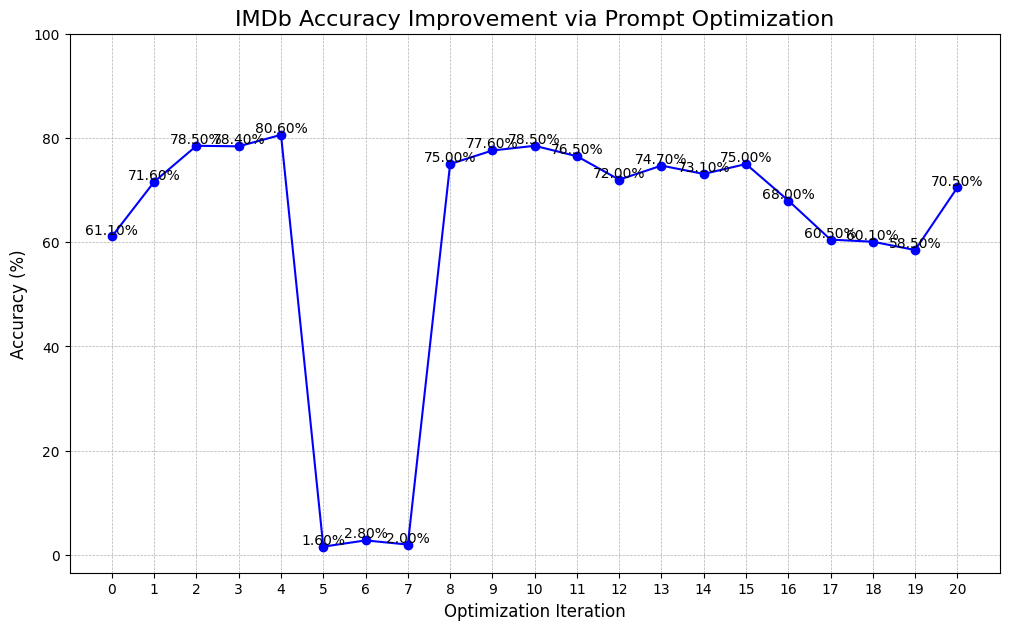

In [5]:
# =================================================================
# FINAL VISUALIZATION
# =================================================================

print("\n--- Optimization Finished. Generating performance graph... ---")

plt.figure(figsize=(12, 7))
plt.plot(range(len(accuracies)), accuracies, marker='o', linestyle='-', color='b')
plt.title("IMDb Accuracy Improvement via Prompt Optimization", fontsize=16)
plt.xlabel("Optimization Iteration", fontsize=12)
plt.ylabel("Accuracy (%)", fontsize=12)
plt.xticks(range(len(accuracies)))
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.ylim(min(accuracies) - 5, 100) 
for i, acc in enumerate(accuracies):
    plt.text(i, acc + 0.5, f"{acc:.2f}%", ha='center')

graph_path = os.path.join(OUTPUT_DIR, "accuracy_improvement_graph.png")
plt.savefig(graph_path)

print(f"✅ Performance graph saved to {graph_path}")

In [6]:
# =================================================================
# SAVE THE BEST PERFORMING INSTRUCTION
# =================================================================

print("\n--- Finding and saving the best performing instruction... ---")

try:
    best_result = max(instruction_history, key=lambda x: x['accuracy'])

    best_instruction_data = {
        "best_iteration": best_result["iteration"],
        "best_accuracy": f"{best_result['accuracy']:.2f}%",
        "best_instruction": best_result["instruction"]
    }
    
    best_result_path = os.path.join(OUTPUT_DIR, "best_result.json")
    with open(best_result_path, 'w', encoding='utf-8') as f:
        json.dump(best_instruction_data, f, indent=4)

    print(f"🏆 Best instruction found at Iteration #{best_result['iteration']} with {best_result['accuracy']:.2f}% accuracy.")
    print(f"✅ Best result saved to {best_result_path}")

except Exception as e:
    print(f"❌ Could not save the best result. Error: {e}")


--- Finding and saving the best performing instruction... ---
🏆 Best instruction found at Iteration #4 with 80.60% accuracy.
✅ Best result saved to ./optimization_results/best_result.json
